In [1]:
%load_ext autoreload
%autoreload 2

# 绘制TDA和Acc之间的相关性

## 首先需要定义一些函数

### 计算相关性的函数

In [2]:
# 这里需要定义一个计算相关性的函数
# 计算的是*spearman correlation*

from scipy.stats import spearmanr

def calculate_spearman_correlation(vector1, vector2):
    """
    Calculate the Spearman correlation between two vectors.

    Parameters:
    - vector1 (array-like): The first vector.
    - vector2 (array-like): The second vector.

    Returns:
    - float: The Spearman correlation coefficient.
    - float: The two-tailed p-value for a hypothesis test whose null hypothesis is that the two samples are uncorrelated.
    """
    correlation_coefficient, p_value = spearmanr(vector1, vector2)
    return correlation_coefficient, p_value

# Example Usage:
vector1 = [1, 2, 3, 4, 5]
vector2 = [2, 3, 1, 4, 5]

correlation, p_value = calculate_spearman_correlation(vector1, vector2)

print(f"Spearman Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")


Spearman Correlation Coefficient: 0.7
P-value: 0.1881204043741873


### 计算数据中的相关性

In [13]:
import pandas as pd
def calculate_correlation_between_excel_sheets(file_path1, sheet_name1, column_name1, file_path2, sheet_name2, column_name2):
    """
    Calculate the Spearman correlation between two columns in different Excel files.

    Parameters:
    - file_path1 (str): Path to the first Excel file.
    - sheet_name1 (str): Name of the sheet in the first Excel file.
    - column_name1 (str): Name of the column in the first sheet for which correlation is calculated.

    - file_path2 (str): Path to the second Excel file.
    - sheet_name2 (str): Name of the sheet in the second Excel file.
    - column_name2 (str): Name of the column in the second sheet for which correlation is calculated.

    Returns:
    - float: The Spearman correlation coefficient.
    - float: The two-tailed p-value for a hypothesis test whose null hypothesis is that the two samples are uncorrelated.
    """
    # Read data from Excel files
    df1 = pd.read_excel(file_path1, sheet_name=sheet_name1)
    df2 = pd.read_excel(file_path2, sheet_name=sheet_name2)

    # Extract columns
    vector1 = df1[column_name1]
    vector2 = df2[column_name2]

    # Calculate Spearman correlation
    correlation_coefficient, p_value = calculate_spearman_correlation(vector1, vector2)

    return correlation_coefficient, p_value

# Example Usage:
file_path1 = 'best_val_acc.xlsx'
sheet_name1 = 'Angle'
column_name1 = 'ResNet18'

file_path2 = 'TDA_out_2_all_bars_surviver_time.xlsx'
sheet_name2 = sheet_name1
column_name2 = column_name1

correlation, p_value = calculate_correlation_between_excel_sheets(file_path1, sheet_name1, column_name1, file_path2, sheet_name2, column_name2)

print(f"Spearman Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")

Spearman Correlation Coefficient: 0.228719098126082
P-value: 0.0020133736873981707


In [34]:
import pandas as pd

def calculate_correlations_for_all_columns(file_path1, file_path2, sheet_names, column_names, if_data=False, excel_path = 'output_file.xlsx'):
    """
    Calculate Spearman correlations for all combinations of sheets and columns between two Excel files.

    Parameters:
    - file_path1 (str): Path to the first Excel file.
    - file_path2 (str): Path to the second Excel file.
    - sheet_names (list): List of sheet names present in both Excel files.
    - column_names (list): List of column names present in each sheet.

    Returns:
    - pd.DataFrame: DataFrame containing correlation coefficients for all combinations.
    """
    correlation_data = []

    for sheet_name in sheet_names:
        for column_name in column_names:
            if if_data:
                correlation_coefficient, p_value = calculate_correlation_between_excel_sheets(
                    file_path1, sheet_name, column_name,
                    file_path2, sheet_name, 'Data'
                )
            else:
                correlation_coefficient, p_value = calculate_correlation_between_excel_sheets(
                    file_path1, sheet_name, column_name,
                    file_path2, sheet_name, column_name
                )
            correlation_data.append({
                'Sheet': sheet_name,
                'Column': column_name,
                'Correlation': correlation_coefficient,
                'P-value': p_value
            })

    correlation_df = pd.DataFrame(correlation_data)
    
    # Sample DataFrame
    data = correlation_df

    df = pd.DataFrame(data)

    # Drop the 'P-value' column
    df = df.drop('P-value', axis=1)

    # Pivot the DataFrame
    df_pivot = df.pivot(index='Sheet', columns='Column', values='Correlation')
    # Set 'Sheet' as the index
    # df_pivot.set_index('Column', inplace=True)

    # Save to Excel
    
    df_pivot.to_excel(excel_path)

    print(f'DataFrame saved to {excel_path}')
    return df_pivot



### 绘制柱形图

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.backends.backend_pdf as pdf_backend

def plot_grouped_bar_chart(file_path1, file_path2, row_index, aug_names = ['Angle', 'Scale']):
    """
    Read specified rows from two Excel files and plot a grouped bar chart.

    Parameters:
    - file_path1 (str): Path to the first Excel file.
    - file_path2 (str): Path to the second Excel file.
    - row_index (int): Index of the row to plot.

    Returns:
    - None
    """
    
    # Read data from Excel files
    df1 = pd.read_excel(file_path1, index_col=0)
    df2 = pd.read_excel(file_path2, index_col=0)

    # Select the specified row
    row_data1 = df1.iloc[row_index]
    row_data2 = df2.iloc[row_index]
    # print(row_data1, '\n', row_data2)

    # Organize data for plotting
    columns = df1.columns
    positions = np.arange(len(columns))
    bar_width = 0.1

    # Plotting
    fig, ax = plt.subplots()
    bars1 = ax.bar(positions - bar_width/2, row_data1, bar_width, label='Data TDA v.s. Acc')
    bars2 = ax.bar(positions + bar_width/2, row_data2, bar_width, label='Model output v.s. Acc')

    # Set labels and title
    ax.set_xlabel('Columns')
    ax.set_ylabel('Spearman orrelation')
    ax.set_title(f'Spearman orrelation between Acc and TDA in {aug_names[row_index]}')
    ax.set_xticks(positions)
    ax.set_xticklabels(columns)
    ax.legend()

    # Save the plot as PDF
    pdf = pdf_backend.PdfPages(f"Spearman orrelation between Acc and TDA in {aug_names[row_index]}.pdf")
    pdf.savefig(fig)
    pdf.close()

    # Show the plot
    plt.show()


## 计算相关性和画图

In [44]:
# Example Usage:
file_path1 = 'best_val_acc.xlsx'
file_path2 = 'TDA_out_2_all_bars_surviver_time.xlsx'
file_path_data = 'TDA_data.xlsx'
sheet_names = ['Scale', 'Angle']
column_names = ['MLP', 'LeNet', 'ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'ResNet152']

correlation_df = calculate_correlations_for_all_columns(file_path1, file_path2, sheet_names, column_names, excel_path='TDA_output_correlation.xlsx')
correlation_df_data = calculate_correlations_for_all_columns(file_path1, file_path_data, sheet_names, column_names, if_data=True, excel_path='TDA_data_correlation.xlsx')
# Display the resulting DataFrame
print(correlation_df)
print(correlation_df_data)

DataFrame saved to TDA_output_correlation.xlsx
DataFrame saved to TDA_data_correlation.xlsx
Column     LeNet       MLP  ResNet101  ResNet152  ResNet18  ResNet34  ResNet50
Sheet                                                                         
Angle   0.627330  0.214745   0.157393        NaN  0.228719  0.228476  0.198327
Scale   0.713087  0.730827   0.762466   0.767893  0.835214  0.832675  0.703158
Column     LeNet       MLP  ResNet101  ResNet152  ResNet18  ResNet34  ResNet50
Sheet                                                                         
Angle   0.199562  0.205292   0.185225   0.023979  0.194427  0.219589  0.194017
Scale   0.836253  0.780351   0.859108   0.848006  0.879741  0.761317  0.868447


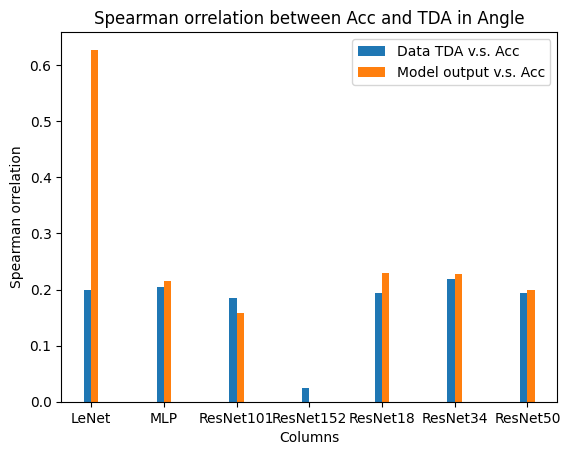

In [57]:
# Example Usage:
file_path1 = 'TDA_data_correlation.xlsx'
file_path2 = 'TDA_output_correlation.xlsx'
row_index = 0  # Choose the row index to plot

plot_grouped_bar_chart(file_path1, file_path2, row_index)
